# A/B testing and power analysis

## What is A/B Testing?

A/B testing is a methodology for testing the efficacy of a new product or feature on the internet. To run the experiment, you need 2 sets of users --

1. a "control" set that uses the pre-existing product or feature
2. an "experiment" set that uses a new, experimental version

Then you measure how users respond differently between the two sets to determine if the feature is "better."

Some examples --

* "Our experiments demonstrate that slowing down the search results page by 100 to 400 milliseconds has a measurable impact on the number of searches per user of -0.2% to -0.6%" ([Google Research Blog](https://research.googleblog.com/2009/06/speed-matters.html))
* "'Add more color to your professional identity by showing what you care about' [...] The A/B test showed a 14% increase in edits of volunteer experience in member profiles!" ([LinkedIn Engineering Blog](https://engineering.linkedin.com/ab-testing/xlnt-platform-driving-ab-testing-linkedin))
* "Identify artwork that enabled members to find a story they wanted to watch faster." ([Netflix Tech Blog](https://medium.com/netflix-techblog/selecting-the-best-artwork-for-videos-through-a-b-testing-f6155c4595f6))

## An example business case: funnel analysis

Imagine that you're a data scientist working at a startup that sells fidget spinners. Despite the highly game-changing nature of the company's product, sales are not too impressive. You wonder if the company's online store experience can be modified somehow to augment sales. Fortunately, your web developer coworker already equiped the website with tools to track traffic! You add up the visits to each page of the site over the past month, and you observe the following funnel in the user flow --

1. Visit the front page (**60,000** visits)
2. Visit the catalog page (**5,000** visits)
3. Visit a product spinner details page (**4,900** visits)
4. Visit cart page (**4,700** visits)
5. Checkout and payment page (**4,600** visits)
6. Payment confirmation page (**4,600** visits)

A major bottle neck in the visitor-to-sale conversion rate seems to be happening between steps 1 and 2. Once users get to the catalog page and see the fidget spinners, the product pretty much sells itself. Many serious meetings take place after you share this funnel analysis with your company, and a new design is proposed for the button on the front page linking to the catalog page (a very slick, animated button that looks and spins exactly like a real fidget spinner).

You've been assigned the task of designing and running an experiment to determine if the proposed animated button is a good idea.

## Refining the problem
### Initial hypothesis
Changing the catalog button to a spinning fidget button will increase the number of users who visit the catalog page.

### Possible metrics
1. Click-through rate (CTR)
$$\text{CTR} = \frac{\text{# of clicks}}{\text{# of page views}}$$
  - Good for measuring __usability__ of the site (includes double-clicks or going back and re-clicking)
2. Click-through probability (CTP)
$$\text{CTP} = \frac{\text{# of unique visitors who click at least once}}{\text{# of unique visitors to the page}}$$
  - Good for measuring __impact__ (e.g. are users progressing to the next level of the funnel?)
  - Some ways to measure: $$\frac{\text{# of cookies that click}}{\text{# of cookies}}\text{ or }\frac{\text{# of page views w/ click}}{\text{# of page views}}$$

The chosen metric matters, e.g. if $\text{user}_{1}$ clicks 0 times and $\text{user}_{2}$ clicks 5 times, then $\text{CTR} = 2.5$ and $\text{CTP} = 0.5$.

### Reframe hypothesis in terms of a chosen metric
Changing the catalog button to a spinning fidget button will increase the __click-through-probability__ of the button.

## Clicks by visitors can be described as a binomial distribution

Properties of a binomial distribution:
1. Two possible outcomes: success or failure (click or no click)
2. Independent events
3. Identical distribution (probability of success is the same for all events)

This means that if the true probability of clicks is $p$, the total population size (e.g. total visitors) is $n$, and the number of successes is $x$, then the distribution has the following properties:

$$\text{population mean} = p = \frac{x}{n}$$
$$\text{population standard deviation} = \sigma = \sqrt{\frac{\left(p\right)\left(1-p\right)}{n}}$$

When we do $N$ experiments (i.e. Bernoulli trails) and count $X$ successes to measure an unknown probability of success, we get the following

$$\text{sample mean} = \hat{p} = \frac{X}{N}$$
$$\text{sample standard error} = SE = \sqrt{\frac{\left(\hat{p}\right)\left(1-\hat{p}\right)}{N}}$$

## Confidence interval calculation

If we can approximate the sample as a normal distribution, then we can calculate the margin of error around the mean for a desired confidence interval. The following criteria are typically checked before assuming a normal distribution.

$$N \times \hat{p} \gt 5$$
$$N \times \left(1 - \hat{p}\right) \gt 5$$

One can see that binomial distribution is too truncated to use a normal approximation when these criteria are not true.

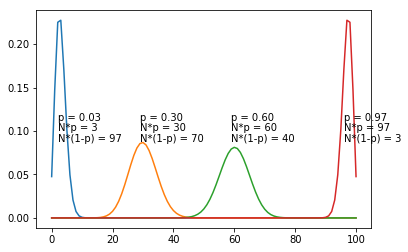

In [117]:
import matplotlib.pyplot as plt
import scipy
from scipy.stats import binom 
N = 100
ps = [0.03, 0.3, 0.6, 0.97]
for idx, p in enumerate(ps):
    x = scipy.linspace(0, N, N + 1)
    plt.plot(x, binom.pmf(x, N, p))
    text_x = (N * p) - 1
    text_y = 0.1
    plt.text(text_x, text_y + 0.012, 'p = {:.2f}'.format(p))
    plt.text(text_x, text_y, 'N*p = {:.0f}'.format(N * p))
    plt.text(text_x, text_y - 0.012, 'N*(1-p) = {:.0f}'.format(N * (1-p)))
plt.show()

If the normal approximation is valid, then we can use the z-score to calculate a two-tailed 95% confidence interval.

In [127]:
from scipy.stats import norm
one_tailed_confidence_interval = 0.975
z_score = norm.ppf(one_tailed_confidence_interval)
print('z-score for two-tailed 95% confidence interval: {:.2f}'.format(z_score))

z-score for two-tailed 95% confidence interval: 1.96


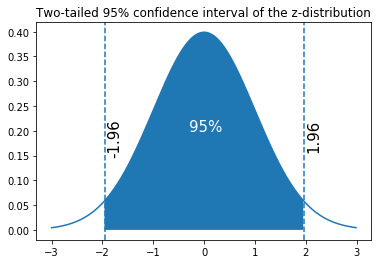

In [165]:
import numpy as np
x_axis = np.arange(-3, 3, 0.01)
plt.plot(x_axis, norm.pdf(x_axis,0,1))
x_axis_fill = np.arange(-z_score, z_score, 0.01)
plt.fill_between(x_axis_fill, norm.pdf(x_axis_fill,0,1))
text_y = 0.2
plt.axvline(z_score, linestyle='dashed')
plt.axvline(-z_score, linestyle='dashed')
plt.text(-0.3, text_y, '95%', color='white', size=15)
plt.text(z_score + 0.05, text_y, '{:0.2f}'.format(z_score), size=15, rotation=90)
plt.text(- z_score + 0.05, text_y, '-{:0.2f}'.format(z_score), size=15, rotation=90)
plt.title('Two-tailed 95% confidence interval of the z-distribution')
plt.show()

So, if $X = 300$, $N = 2000$, and the confidence interval is 99%, the margin of error is as follows.

z-score for two-tailed 99% confidence interval: 2.58


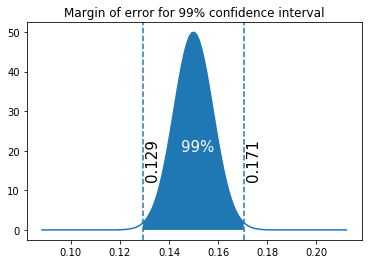

In [214]:
one_tailed_confidence_interval = 0.995
z_score = norm.ppf(one_tailed_confidence_interval)
print('z-score for two-tailed 99% confidence interval: {:.2f}'.format(z_score))

X = 300
N = 2000
p = X / N
SE = (p * (1-p) / N)**0.5
margin_of_error = z_score * SE

step_size = 0.001
x_axis = np.arange(p - 3*margin_of_error, p + 3*margin_of_error + step_size, step_size)
plt.plot(x_axis, norm.pdf(x_axis, p, SE))
x_axis_fill = np.arange(p - margin_of_error, p + margin_of_error, step_size)
plt.fill_between(x_axis_fill, norm.pdf(x_axis_fill, p, SE))
text_y = 20
plt.axvline(p + margin_of_error, linestyle='dashed')
plt.axvline(p - margin_of_error, linestyle='dashed')
plt.text(p - 0.005, text_y, '99%', color='white', size=15)
plt.text(p + margin_of_error + 0.001, text_y, '{:0.3f}'.format(p + margin_of_error), size=15, rotation=90)
plt.text(p - margin_of_error + 0.001, text_y, '{:0.3f}'.format(p - margin_of_error), size=15, rotation=90)
plt.title('Margin of error for 99% confidence interval')
plt.show()
